In [1]:
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf
# !pip install squarify

In [2]:
cd /content/drive/MyDrive/kakao

/content/drive/MyDrive/kakao


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumBarunGothic'
import seaborn as sns 
import warnings 
warnings.filterwarnings('ignore')
from tqdm import tqdm

import squarify


In [4]:
def load_dataset() : 
  data = pd.read_csv('DATASET/2019-Nov.csv', chunksize = 1000000)
  data = list(data)
  data = pd.concat(data)
  return data

data = load_dataset()
data.shape

(67501979, 9)

In [5]:
data.head()

,event_time,event_type,product_id,category_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,2053013555631882655,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,2053013566100866035,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,2053013553853497655,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,2053013563810775923,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,2053013555631882655,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


In [6]:
data.dtypes

event_time        object
event_type        object
product_id         int64
category_id        int64
category_code     object
brand             object
price            float64
user_id            int64
user_session      object
dtype: object

In [7]:
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
      if col != 'price' :
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    df.drop(columns = ['category_id'], inplace = True)
    df['event_type']=df['event_type'].astype('category')
    df['category_code']=df['category_code'].astype('category')
    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df

In [8]:
data=reduce_mem_usage(data)

Memory usage after optimization is: 2768.13 MB
Decreased by 40.3%


In [9]:
data.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session
0,2019-11-01 00:00:00 UTC,view,1003461,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33
1,2019-11-01 00:00:00 UTC,view,5000088,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283
2,2019-11-01 00:00:01 UTC,view,17302664,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387
3,2019-11-01 00:00:01 UTC,view,3601530,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f
4,2019-11-01 00:00:01 UTC,view,1004775,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2


**날짜, 시간 변수 생성**

In [10]:
data['event_time'] = pd.to_datetime(data['event_time'])
data['date'] = data['event_time'].dt.day
data['hour'] = data['event_time'].dt.hour
data['dayname'] = data['event_time'].dt.day_name()
data['week'] = data['event_time'].dt.week

In [11]:
# data['event_time'] = pd.to_datetime(data['event_time'])
# data['date'] = [x.day for x in data['event_time']]
# data['hour'] = [x.hour for x in data['event_time']]
# data['dayname'] = data['event_time'].dt.day_name()
# data['week'] = data['event_time'].dt.week()
# data.drop('category_id', axis = 1, inplace = True)

In [12]:
data.head()

,event_time,event_type,product_id,category_code,brand,price,user_id,user_session,date,hour,dayname,week
0,2019-11-01 00:00:00+00:00,view,1003461,electronics.smartphone,xiaomi,489.07,520088904,4d3b30da-a5e4-49df-b1a8-ba5943f1dd33,1,0,Friday,44
1,2019-11-01 00:00:00+00:00,view,5000088,appliances.sewing_machine,janome,293.65,530496790,8e5f4f83-366c-4f70-860e-ca7417414283,1,0,Friday,44
2,2019-11-01 00:00:01+00:00,view,17302664,NaN,creed,28.31,561587266,755422e7-9040-477b-9bd2-6a6e8fd97387,1,0,Friday,44
3,2019-11-01 00:00:01+00:00,view,3601530,appliances.kitchen.washer,lg,712.87,518085591,3bfb58cd-7892-48cc-8020-2f17e6de6e7f,1,0,Friday,44
4,2019-11-01 00:00:01+00:00,view,1004775,electronics.smartphone,xiaomi,183.27,558856683,313628f1-68b8-460d-84f6-cec7a8796ef2,1,0,Friday,44


In [13]:
dow_dict = {
    'Monday' : 0,
    'Tuesday' : 1,
    'Wednesday' : 2,
    'Thursday' : 3,
    'Friday' : 4,
    'Saturday' : 5, 
    'Sunday' : 6
}
data['dayname'] = data['dayname'].map(dow_dict)
data['dayname'] = data['dayname'].astype(np.int8)

## Conversion Rates

In [14]:
view_cnt = data['event_type'].value_counts()['view']
cart_cnt = data['event_type'].value_counts()['cart']
purchase_cnt = data['event_type'].value_counts()['purchase']
print('Conversion rate between view and purchase : ', purchase_cnt/view_cnt*100, '%')
print('Conversion rate between view and add-to-cart : ', cart_cnt/view_cnt*100, '%')
print('Conversion rate between add-to-cart and purchase : ', purchase_cnt/cart_cnt*100, '%')

Conversion rate between view and purchase :  1.442723602813325 %
Conversion rate between view and add-to-cart :  4.765757375648069 %
Conversion rate between add-to-cart and purchase :  30.27270356198393 %


## Brand Sales

In [15]:
# view, cart, purchase 모두 고려 
data['brand'].value_counts().head(50)

samsung     7889245
apple       6259379
xiaomi      4638062
huawei      1410126
lucente     1185075
lg          1096990
bosch        975059
oppo         811698
sony         798457
respect      765331
lenovo       727390
acer         698976
cordiant     671671
artel        664281
hp           515352
asus         469241
redmond      462034
philips      456155
indesit      428863
dauscher     416173
vitek        396115
casio        374343
tefal        350030
polaris      330164
brw          299471
beko         293812
midea        282568
nokian       279992
baden        276407
sv           266870
haier        262055
elenberg     252822
nokia        252730
sokolov      248831
stels        247896
viatti       246531
janome       211368
meizu        209299
starline     208087
pioneer      201799
braun        199426
triangle     197979
hansa        183921
karcher      182913
jbl          179964
scarlett     178455
rieker       170727
bts          165579
vivo         159327
force        149441


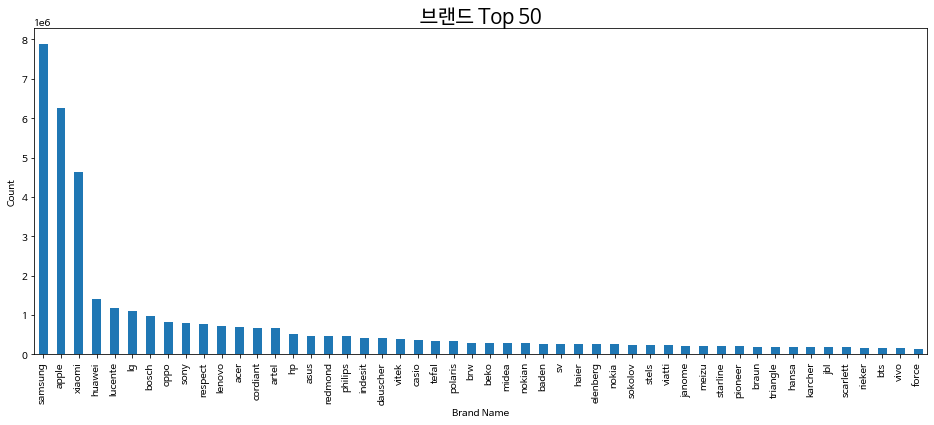

In [16]:
# view, cart, purchase 모두 고려 
data['brand'].value_counts().head(50).plot.bar(figsize = (16, 6))
plt.title('브랜드 Top 50', fontsize = 20)
plt.xlabel('Brand Name')
plt.ylabel('Count')
plt.show()

In [17]:
# purchase만 고려 
data[data['event_type'] == 'purchase']['brand'].value_counts().head(50)

samsung     200027
apple       166064
xiaomi       68292
huawei       23703
cordiant     16983
oppo         15080
lucente      14559
lg           12879
sony         10309
artel         9267
bosch         8010
lenovo        6547
acer          6402
nokian        5981
viatti        5578
philips       5539
vitek         5423
indesit       5187
redmond       5120
triangle      4741
respect       4740
elenberg      4655
dauscher      4221
tefal         4178
hp            4106
midea         4004
beko          3884
haier         3847
polaris       3545
casio         3523
asus          3062
stels         2768
starline      2731
nokia         2640
yokohama      2633
jbl           2630
matador       2504
braun         2491
tunga         2375
arg           2336
meizu         2147
janome        2142
sokolov       2123
rowenta       2064
ariston       1942
vivo          1914
omron         1698
scarlett      1690
roadx         1658
kapsen        1653
Name: brand, dtype: int64

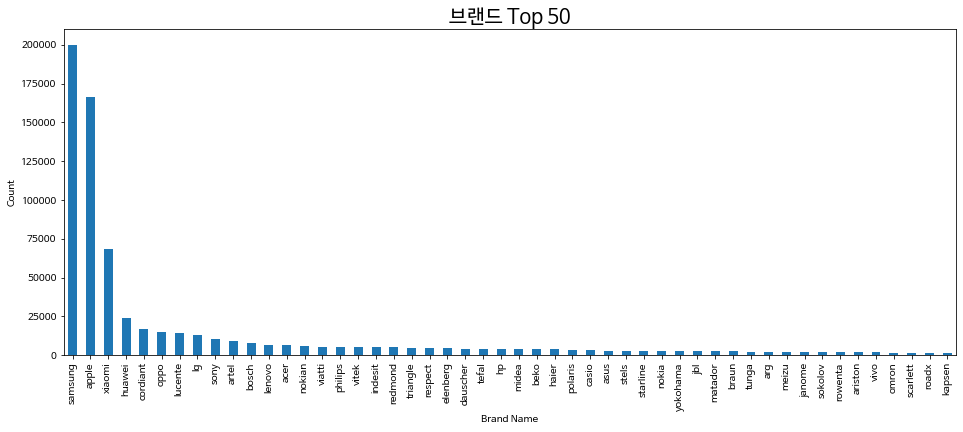

In [18]:
# purchase만 고려 
data[data['event_type'] == 'purchase']['brand'].value_counts().head(50).plot.bar(figsize = (16, 6))
plt.title('브랜드 Top 50', fontsize = 20)
plt.xlabel('Brand Name')
plt.ylabel('Count')
plt.show()

## 총 구매액, 일별 구매액

In [19]:
# 총 구매액
data[data['event_type'] == 'purchase'].groupby('date')['price'].sum()

date
1      6949415.03
2      6389808.37
3      6656920.09
4      8033899.65
5      7250120.41
6      7397760.63
7      7062018.53
8      7742039.59
9      6646804.30
10     6633475.29
11     7255189.94
12     6782115.20
13     6812879.77
14     6949925.13
16    23442969.87
17    57774481.92
18     8251007.90
19     7291407.76
20     7089210.27
21     6970110.37
22     6990846.23
23     6339110.07
24     6470750.90
25     7053766.60
26     6893392.91
27     7161341.26
28     7163831.66
29     9635318.38
30     8104972.47
Name: price, dtype: float64

In [20]:
# 총 구매액
data[data['event_type'] == 'purchase']['price'].sum()

275194890.50000006

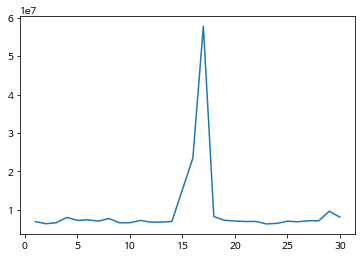

In [21]:
# plot
plt.plot(data[data['event_type'] == 'purchase'].groupby('date')['price'].sum())

In [22]:
purchase_df = data[data['event_type'] == 'purchase']

In [23]:
purchase_df[purchase_df['date'] == 10]['brand'].value_counts(normalize = False).sort_values(ascending = False)

samsung           5110
apple             3946
xiaomi            1602
huawei             607
lucente            417
                  ... 
florentina           1
genius               1
tizianaterenzi       1
author               1
fitbit               1
Name: brand, Length: 852, dtype: int64

In [24]:
purchase_df[purchase_df['date'] == 17]['brand'].value_counts(normalize = False).sort_values(ascending = False)

samsung      33634
apple        32168
xiaomi       12741
huawei        4242
lg            4062
             ...  
leica            1
pandect          1
samo             1
venta            1
wonderlab        1
Name: brand, Length: 1703, dtype: int64

## 카테고리별 구매액

In [25]:
category_price_df = purchase_df[purchase_df['category_code'].notnull()][['category_code', 'price']]
category_price_df

,category_code,price
107,furniture.bedroom.bed,566.30
168,electronics.smartphone,211.92
707,electronics.smartphone,128.42
939,electronics.video.tv,488.80
942,electronics.audio.subwoofer,123.56
...,...,...
67501716,electronics.smartphone,235.60
67501725,electronics.smartphone,346.70
67501745,electronics.smartphone,1437.02
67501824,electronics.smartphone,235.60


In [69]:
category_price_df

,category_code,price,category,sub_category
107,furniture.bedroom.bed,566.30,furniture,bedroom
168,electronics.smartphone,211.92,electronics,smartphone
707,electronics.smartphone,128.42,electronics,smartphone
939,electronics.video.tv,488.80,electronics,video
942,electronics.audio.subwoofer,123.56,electronics,audio
...,...,...,...,...
67501716,electronics.smartphone,235.60,electronics,smartphone
67501725,electronics.smartphone,346.70,electronics,smartphone
67501745,electronics.smartphone,1437.02,electronics,smartphone
67501824,electronics.smartphone,235.60,electronics,smartphone


In [26]:
del purchase_df

In [27]:
def category_func(x, level = 0) : 
  if level == 0 : 
    return x.split('.')[0]
  else : 
    return x.split('.')[1]

category_price_df['category'] = category_price_df['category_code'].apply(lambda x : category_func(x, 0))
category_price_df['sub_category'] = category_price_df['category_code'].apply(lambda x : category_func(x, 1))
category_price_df

,category_code,price,category,sub_category
107,furniture.bedroom.bed,566.30,furniture,bedroom
168,electronics.smartphone,211.92,electronics,smartphone
707,electronics.smartphone,128.42,electronics,smartphone
939,electronics.video.tv,488.80,electronics,video
942,electronics.audio.subwoofer,123.56,electronics,audio
...,...,...,...,...
67501716,electronics.smartphone,235.60,electronics,smartphone
67501725,electronics.smartphone,346.70,electronics,smartphone
67501745,electronics.smartphone,1437.02,electronics,smartphone
67501824,electronics.smartphone,235.60,electronics,smartphone


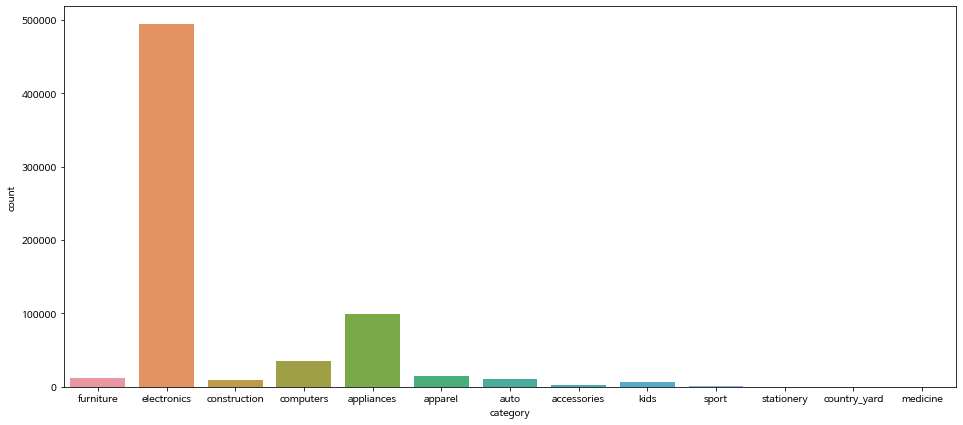

In [28]:
plt.figure(figsize = (16, 7))
sns.countplot(x = 'category', data = category_price_df)
plt.show()

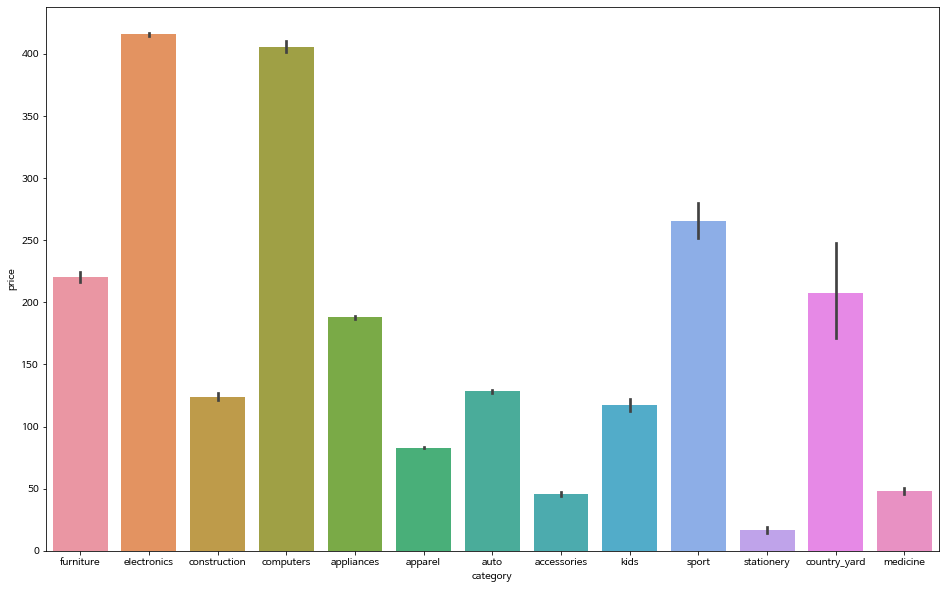

In [29]:
plt.figure(figsize = (16, 10))
sns.barplot(x = 'category', y = 'price', data = category_price_df)
plt.show()

In [30]:
category_price_df.groupby('category')['price'].count().sort_values()

category
country_yard        60
stationery         191
medicine           344
sport             1489
accessories       2154
kids              6166
construction      8699
auto             10719
furniture        11542
apparel          14215
computers        34477
appliances       99026
electronics     493639
Name: price, dtype: int64

In [31]:
category_price_df.groupby('category')['price'].mean().sort_values()

category
stationery       16.819267
accessories      45.591003
medicine         47.799273
apparel          83.083019
kids            117.379705
construction    124.197115
auto            128.277341
appliances      188.238459
country_yard    207.452167
furniture       220.347515
sport           265.743956
computers       405.903376
electronics     415.789916
Name: price, dtype: float64

In [32]:
category_price_df[category_price_df['category'] == 'medicine']

,category_code,price,category,sub_category
382447,medicine.tools.tonometer,40.38,medicine,tools
538576,medicine.tools.tonometer,47.08,medicine,tools
693250,medicine.tools.tonometer,47.08,medicine,tools
721730,medicine.tools.tonometer,33.44,medicine,tools
730863,medicine.tools.tonometer,47.08,medicine,tools
...,...,...,...,...
66674790,medicine.tools.tonometer,48.65,medicine,tools
66696716,medicine.tools.tonometer,48.65,medicine,tools
66742549,medicine.tools.tonometer,41.05,medicine,tools
67130805,medicine.tools.tonometer,84.17,medicine,tools


## view, cart, purchase 비율

In [33]:
data['event_type']

0           view
1           view
2           view
3           view
4           view
            ... 
67501974    view
67501975    view
67501976    view
67501977    view
67501978    view
Name: event_type, Length: 67501979, dtype: category
Categories (3, object): ['cart', 'purchase', 'view']

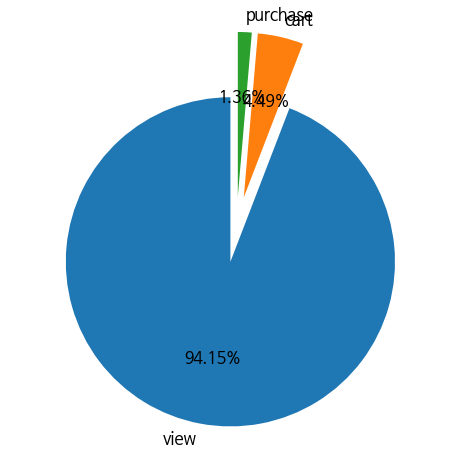

In [34]:
pie_chart_event_type = data['event_type'].value_counts()
f = plt.figure(figsize = (8, 8))
plt.pie(pie_chart_event_type,
        labels = pie_chart_event_type.index,
        autopct = '%.2f%%',
        startangle = 90,
        explode = (0.2, 0.2, 0.2),
        textprops = {'fontsize' : 16}
        )
plt.axis('equal')
plt.show()

## 시간대별 세션 수 vs 구매 수

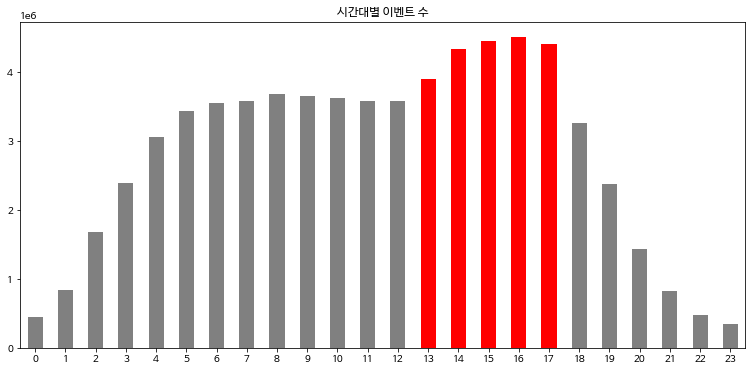

In [35]:
colors = ['gray' for _ in range(13)] + ['red' for _ in range(5)] + ['gray' for _ in range(6)]

f = plt.figure(figsize = (13, 6))
data['hour'].value_counts().sort_index().plot.bar(color = colors)
plt.xticks(rotation=0)
plt.title('시간대별 이벤트 수')
plt.show()

f.savefig("/content/drive/MyDrive/kakao/figure/time_vs_event.pdf", bbox_inches='tight')

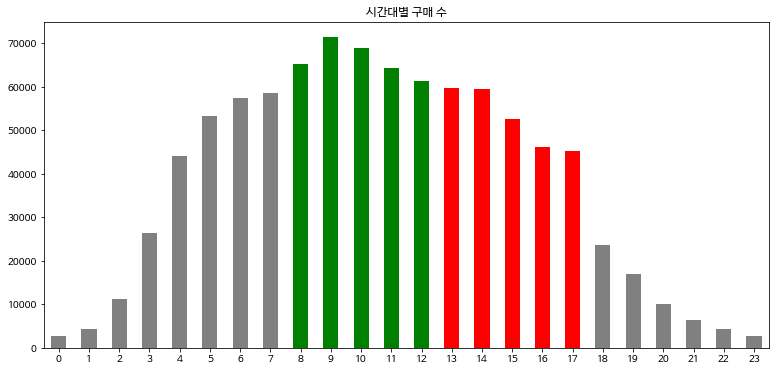

In [36]:
colors = ['gray' for _ in range(8)] + ['green' for _ in range(5)] + ['red' for _ in range(5)] + ['gray' for _ in range(6)]

f = plt.figure(figsize = (13, 6))
data[data['event_type'] == 'purchase']['hour'].value_counts().sort_index().plot.bar(color = colors)
plt.xticks(rotation=0)
plt.title('시간대별 구매 수')
plt.show()

f.savefig("/content/drive/MyDrive/kakao/figure/time_vs_purchase.pdf", bbox_inches='tight')

## Daily Active Users  

In [37]:
dau = data.groupby('date')['user_id'].apply(lambda x : len(np.unique(x)))
dau

date
1     223108
2     234685
3     240187
4     275612
5     262338
6     256887
7     278988
8     286053
9     268643
10    276198
11    292400
12    285994
13    285408
14    308842
15    379786
16    487327
17    487501
18    319537
19    290798
20    291900
21    287079
22    249401
23    249362
24    240526
25    257613
26    252527
27    256546
28    253979
29    286699
30    255497
Name: user_id, dtype: int64

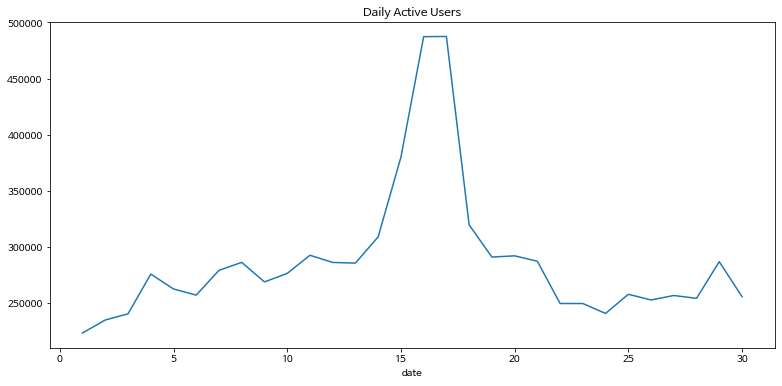

In [38]:
f = plt.figure(figsize = (13, 6))
dau.plot()
plt.title('Daily Active Users')
plt.show()

f.savefig("/content/drive/MyDrive/kakao/figure/dau.pdf", bbox_inches='tight')

## 일별 요약

In [39]:
daily_summary_table = data.groupby(by=[data['event_time'].dt.normalize()]).agg(Number_of_daily_visits = ('user_session',lambda x: x.nunique()),
                                                                               Number_of_daily_visitors = ('user_id',lambda x: x.nunique()))
sales = data[data['event_type']=='purchase'].groupby(by=[data['event_time'].dt.normalize()]).agg(number_of_daily_sales = ('event_type','count'),
                                                                                                 Total_daily_sales=('price','sum')).reset_index()
daily_summary_table=pd.merge(left=daily_summary_table,
                          right=sales,
                          left_on=['event_time'],
                          right_on=['event_time'],
                          how='left')
daily_summary_table['conversion_rate']=daily_summary_table['number_of_daily_sales']/daily_summary_table['Number_of_daily_visits']


In [40]:
daily_summary_table.head()

,event_time,Number_of_daily_visits,Number_of_daily_visitors,number_of_daily_sales,Total_daily_sales,conversion_rate
0,2019-11-01 00:00:00+00:00,320904,223108,22458.0,6949415.03,0.069984
1,2019-11-02 00:00:00+00:00,338769,234685,21864.0,6389808.37,0.064540
2,2019-11-03 00:00:00+00:00,343373,240187,22145.0,6656920.09,0.064493
3,2019-11-04 00:00:00+00:00,396756,275612,26889.0,8033899.65,0.067772
4,2019-11-05 00:00:00+00:00,376362,262338,24875.0,7250120.41,0.066093


### Daily Visits

In [41]:
#Daily Visits
print('Daily Visits Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_visits'].describe())
print('-'*50)
print('Visit Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['Number_of_daily_visits'].describe())

Daily Visits Statistics
--------------------------------------------------
count        30.000000
mean     460826.866667
std      164141.396524
min      320904.000000
25%      383058.750000
50%      403573.000000
75%      453055.000000
max      992493.000000
Name: Number_of_daily_visits, dtype: float64
--------------------------------------------------
Visit Statistics by Dates
--------------------------------------------------
            count       mean            std       min        25%       50%  \
event_time                                                                   
Friday        5.0  472837.60  172185.992474  320904.0  381950.00  444456.0   
Monday        4.0  439579.75   52430.112679  395919.0  396546.75  429998.5   
Saturday      5.0  501287.40  275865.915864  338769.0  372945.00  391840.0   
Sunday        4.0  523868.75  303323.563033  343373.0  354503.00  387898.5   
Thursday      4.0  446545.00   79457.876471  391713.0  395079.00  416305.0   
Tuesday       4.0  414

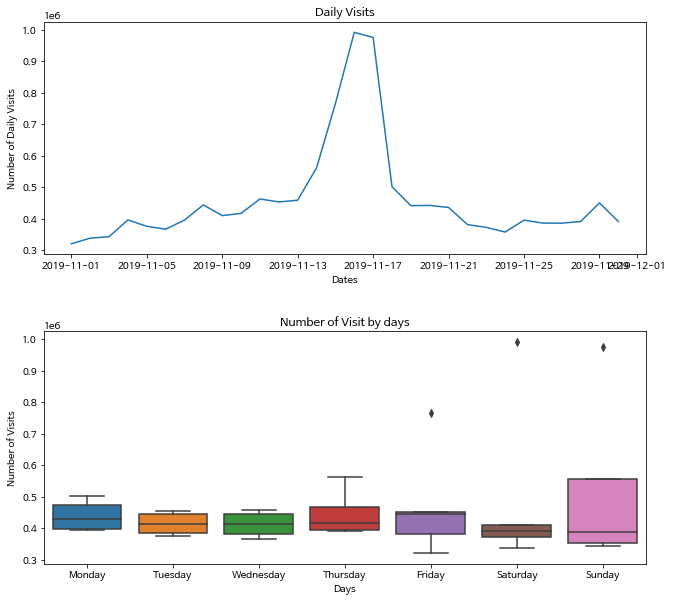

In [42]:
#Plotting number of daily visits
fig=plt.figure(figsize=(10,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='Number_of_daily_visits',
              data=daily_summary_table,
             ax=ax1)
plt.title('Daily Visits')
plt.ylabel('Number of Daily Visits')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)

sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='Number_of_daily_visits',
            data=daily_summary_table,
           ax=ax2)
plt.title('Number of Visit by days')
plt.ylabel('Number of Visits')
plt.xlabel('Days')
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);


### Dailys Visitors 

In [43]:
#Daily Visitors
print('Daily Visitor Statistics')
print('-'*50)
print(daily_summary_table['Number_of_daily_visitors'].describe())
print('-'*50)
print('Visitor Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['Number_of_daily_visitors'].describe())

Daily Visitor Statistics
--------------------------------------------------
count        30.000000
mean     287380.700000
std       62081.636975
min      223108.000000
25%      254358.500000
50%      275905.000000
75%      289868.250000
max      487501.000000
Name: Number_of_daily_visitors, dtype: float64
--------------------------------------------------
Visitor Statistics by Dates
--------------------------------------------------
            count       mean            std       min        25%       50%  \
event_time                                                                   
Friday        5.0  285009.40   59342.837034  223108.0  249401.00  286053.0   
Monday        4.0  286290.50   26325.432070  257613.0  271112.25  284006.0   
Saturday      5.0  299102.80  105926.171007  234685.0  249362.00  255497.0   
Sunday        4.0  311103.00  118806.292502  240187.0  240441.25  258362.0   
Thursday      4.0  282222.00   22659.366378  253979.0  272735.75  283033.5   
Tuesday       4.0

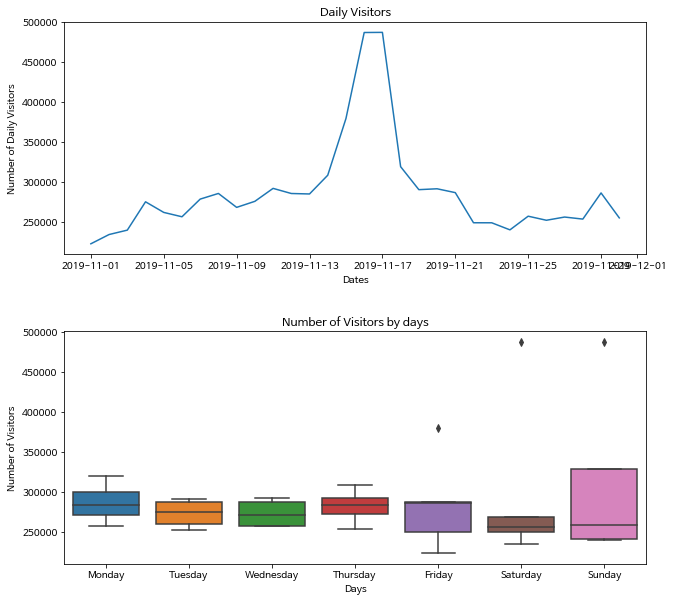

In [44]:
#Plotting number of daily visitors
fig=plt.figure(figsize=(10,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='Number_of_daily_visitors',
              data=daily_summary_table,
            ax=ax1)
plt.title('Daily Visitors')
plt.ylabel('Number of Daily Visitors')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)
sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='Number_of_daily_visitors',
            data=daily_summary_table,
           ax=ax2)
plt.title('Number of Visitors by days')
plt.ylabel('Number of Visitors')
plt.xlabel('Days')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);

### Conversion Rate

In [45]:
#Conversion rates
print('Conversion Rates Statistics')
print('-'*50)
print(daily_summary_table['conversion_rate'].describe())
print('-'*50)
print('Conversion Rates Statistics by Dates')
print('-'*50)
print(daily_summary_table.groupby(by=daily_summary_table['event_time'].dt.day_name())['conversion_rate'].describe())


Conversion Rates Statistics
--------------------------------------------------
count    29.000000
mean      0.065259
std       0.025017
min       0.039377
25%       0.056490
50%       0.062707
75%       0.066093
max       0.189690
Name: conversion_rate, dtype: float64
--------------------------------------------------
Conversion Rates Statistics by Dates
--------------------------------------------------
            count      mean       std       min       25%       50%       75%  \
event_time                                                                      
Friday        4.0  0.065594  0.006215  0.057855  0.061958  0.066654  0.070291   
Monday        4.0  0.060275  0.006215  0.053819  0.056055  0.059754  0.063973   
Saturday      5.0  0.064067  0.006655  0.055479  0.059642  0.064540  0.068763   
Sunday        4.0  0.093408  0.064354  0.054787  0.062066  0.064578  0.095919   
Thursday      4.0  0.055518  0.010973  0.039377  0.053266  0.059972  0.062224   
Tuesday       4.0  0.0588

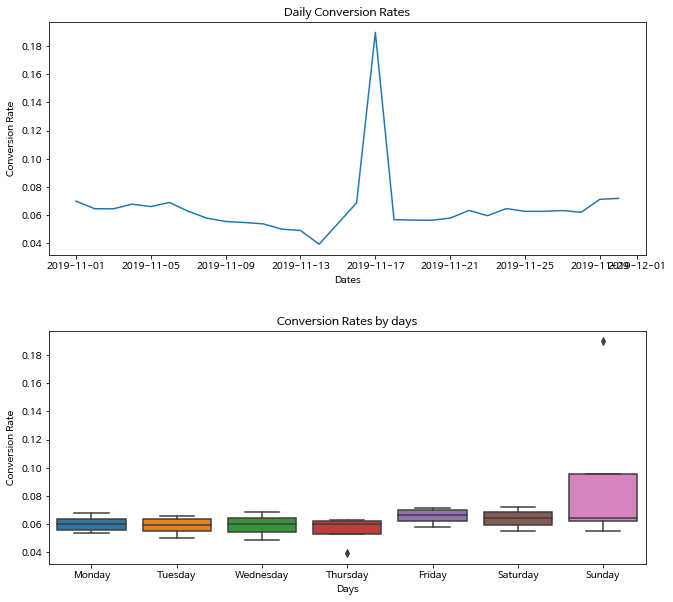

In [46]:
#Plotting convergance rates
fig=plt.figure(figsize=(10,9))
ax1=fig.add_subplot(2,1,1)
sns.lineplot(x='event_time',
              y='conversion_rate',
              data=daily_summary_table,
            ax=ax1)
plt.title('Daily Conversion Rates')
plt.ylabel('Conversion Rate')
plt.xlabel('Dates')

ax2=fig.add_subplot(2,1,2)
sns.boxplot(x=daily_summary_table['event_time'].dt.dayofweek,
            y='conversion_rate',
            data=daily_summary_table,
           ax=ax2)
plt.title('Conversion Rates by days')
plt.ylabel('Conversion Rate')
plt.xlabel('Days')
plt.xticks([0, 1, 2,3,4,5,6], ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday'])
fig.tight_layout(pad=3.0);

## Custmoers who purchased more than once.

## 고객 분석

In [47]:
#Customer table
Customer_table = data[data['event_type'] == 'purchase'].groupby('user_id').agg(number_of_purchases=('user_id','count'),
                                                                               total_sales=('price','sum')).reset_index()
Customer_table.head()

,user_id,number_of_purchases,total_sales
0,138340325,1,93.50
1,225644257,1,40.91
2,253299396,1,246.85
3,256164170,1,113.23
4,267316896,1,189.71


In [48]:
#Calculating number of customers who bought something
Number_of_customers_who_bought_smt=Customer_table['user_id'].nunique()
print('There are {:,.0f} customers, who purchased in October.'.format(Number_of_customers_who_bought_smt))

#Calculating number of purchase activities for each customer
print('-'*50)
print('Distribution of Customer by Number of Purchases')
print(Customer_table['number_of_purchases'].value_counts(normalize=True).head(10))
#Calculationg repeat customers number
print('-'*50)
more_than_one_purchase_filter=Customer_table['number_of_purchases']>1
Number_of_customers_who_bought_more_than_once=Customer_table.loc[more_than_one_purchase_filter].shape[0]
print('There are {:,.0f} repeat customers, who bought more than once.'.format(Number_of_customers_who_bought_more_than_once))

There are 441,638 customers, who purchased in October.
--------------------------------------------------
Distribution of Customer by Number of Purchases
1     0.618710
2     0.193074
3     0.077557
4     0.037603
5     0.021153
6     0.012786
7     0.008785
8     0.006145
9     0.004452
10    0.003367
Name: number_of_purchases, dtype: float64
--------------------------------------------------
There are 168,392 repeat customers, who bought more than once.


In [49]:
print('There are {:,.0f} customers, who purchased product.'.format(Customer_table['user_id'].nunique()))

There are 441,638 customers, who purchased product.


In [50]:
#Calculating number of purchase activities for each customer
print('-'*50)
print('Distribution of Customer by Number of Purchases')
print(Customer_table['number_of_purchases'].value_counts(normalize=True).head(10))
#Calculationg repeat customers number
print('-'*50)
more_than_one_purchase_filter=Customer_table['number_of_purchases']>1
Number_of_customers_who_bought_more_than_once=Customer_table.loc[more_than_one_purchase_filter].shape[0]
print('There are {:,.0f} repeat customers, who bought more than once.'.format(Number_of_customers_who_bought_more_than_once))

--------------------------------------------------
Distribution of Customer by Number of Purchases
1     0.618710
2     0.193074
3     0.077557
4     0.037603
5     0.021153
6     0.012786
7     0.008785
8     0.006145
9     0.004452
10    0.003367
Name: number_of_purchases, dtype: float64
--------------------------------------------------
There are 168,392 repeat customers, who bought more than once.


In [51]:
#filtering out the extreme values
sales_threshold=np.percentile(Customer_table['total_sales'],[1,95])
sales_threshold_filter=np.logical_and(Customer_table['total_sales']>=sales_threshold[0],
                                      Customer_table['total_sales']<=sales_threshold[1])
sales_filtered=Customer_table.loc[sales_threshold_filter]
print(Customer_table.describe())
print(sales_filtered.describe())


            user_id  number_of_purchases    total_sales
count  4.416380e+05        441638.000000  441638.000000
mean   5.420398e+08             2.076223     623.123215
std    2.272761e+07             3.331094    1642.314776
min    1.383403e+08             1.000000       0.770000
25%    5.186410e+08             1.000000     108.600000
50%    5.418407e+08             1.000000     246.040000
75%    5.653120e+08             2.000000     616.920000
max    5.799671e+08           519.000000  203986.070000
            user_id  number_of_purchases    total_sales
count  4.151440e+05        415144.000000  415144.000000
mean   5.421175e+08             1.713263     401.615123
std    2.275459e+07             1.479059     437.170288
min    1.383403e+08             1.000000      10.630000
25%    5.186590e+08             1.000000     106.050000
50%    5.419688e+08             1.000000     235.100000
75%    5.654641e+08             2.000000     527.505000
max    5.799671e+08            64.000000    2187

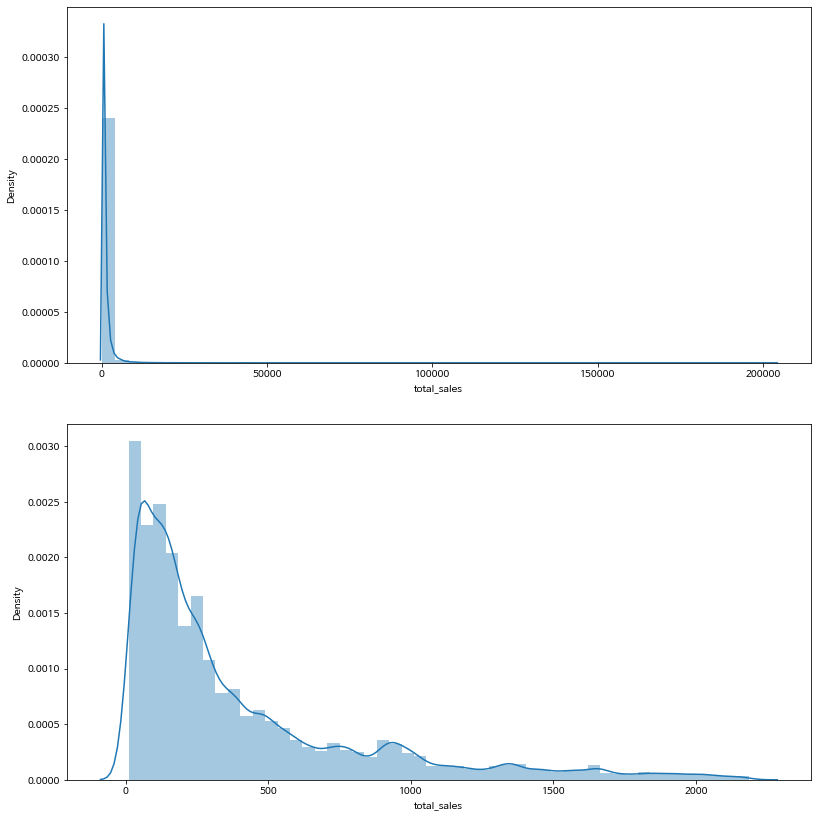

In [52]:
fig=plt.figure(figsize=(12,12))
ax1=fig.add_subplot(2,1,1)
sns.distplot(Customer_table['total_sales'],
            ax=ax1)

ax2=fig.add_subplot(2,1,2)
sns.distplot(sales_filtered['total_sales'],
            ax=ax2)

fig.tight_layout(pad=3.0);

In [53]:
#Most valuable customers

#filtering customer with top %10 purchase amount
top10perc_sales_amount=np.percentile(Customer_table['total_sales'],90)
filter_top10perc_sales_amount=Customer_table['total_sales']>=top10perc_sales_amount
top10perc_customers_with_hightest_turnover=Customer_table.loc[filter_top10perc_sales_amount]
regular_customers=Customer_table.loc[~filter_top10perc_sales_amount]

In [54]:
#calculating descriptive statistics
print('Top 10% customers Purchase Amount-Descriptive Statistics')
print('-'*50)
print(top10perc_customers_with_hightest_turnover['total_sales'].describe())
print('-'*50)
total_sales_amount=Customer_table['total_sales'].sum()
print('Total sales: {:,.0f}'.format(total_sales_amount))
total_sales_amount_top10perc=top10perc_customers_with_hightest_turnover['total_sales'].sum()
print('Total sales of top 10% customers: {:,.0f}'.format(total_sales_amount_top10perc))


Top 10% customers Purchase Amount-Descriptive Statistics
--------------------------------------------------
count     44402.000000
mean       3296.990949
std        4243.066739
min        1364.000000
25%        1661.050000
50%        2177.090000
75%        3362.127500
max      203986.070000
Name: total_sales, dtype: float64
--------------------------------------------------
Total sales: 275,194,890
Total sales of top 10% customers: 146,392,992


In [55]:
#calculating descriptive statistics
print('Regular customers Purchase Amount-Descriptive Statistics')
print('-'*50)
print(regular_customers['total_sales'].describe())
print('-'*50)
total_sales_amount_regular_customers=regular_customers['total_sales'].sum()
print('Total sales of regular customers: {:,.0f}'.format(total_sales_amount_regular_customers))

Regular customers Purchase Amount-Descriptive Statistics
--------------------------------------------------
count    397236.000000
mean        324.245281
std         312.789457
min           0.770000
25%          95.210000
50%         206.450000
75%         457.402500
max        1363.970000
Name: total_sales, dtype: float64
--------------------------------------------------
Total sales of regular customers: 128,801,898


In [61]:
total_sales_amount_regular_customers

128801898.4

In [63]:
del Customer_table
del top10perc_customers_with_hightest_turnover
del regular_customers